## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Loading the dataset

In [34]:
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    

IMAGES_DIR = 'C:\\Users\\User\\Downloads\\Garbage classification\\Garbage classification'   # Ganti dengan lokasi direktori IMAGES_DIR yang sesuai
    
train_file = 'one-indexed-files-notrash_train.txt'
val_file   = 'one-indexed-files-notrash_val.txt'
test_file  = 'one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])

df_train = add_class_name_prefix(df_train, 'path')
df_valid = add_class_name_prefix(df_valid, 'path')
df_test  = add_class_name_prefix(df_test,  'path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


## Image Preprocessing

In [35]:
# ImageDataGenerator: For data preprocessing
# flow_from_dataframe: Takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data

gen = ImageDataGenerator(rescale=1./255)    # rescaling the images between 0 and 1

gen_train = gen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

gen_valid = gen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

test_gen = gen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


## Model

In [36]:
# Function defining model architecture

def build_model(num_classes):
    # Loading pre-trained ResNet model
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    base_model.trainable = False
        
    return model

model = build_model(num_classes=6)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

58892288/58889256 [==============================] - 62s 1us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

## Training

In [37]:
# Model training

history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=30
)

Epoch 1/30
56/56 [==============================] - 726s 13s/step - loss: 1.3829 - categorical_accuracy: 0.4576 - val_loss: 1.1850 - val_categorical_accuracy: 0.5427
Epoch 2/30
56/56 [==============================] - 716s 13s/step - loss: 1.0707 - categorical_accuracy: 0.5820 - val_loss: 0.9865 - val_categorical_accuracy: 0.6372
Epoch 3/30
56/56 [==============================] - 722s 13s/step - loss: 0.9073 - categorical_accuracy: 0.6725 - val_loss: 0.8547 - val_categorical_accuracy: 0.6982
Epoch 4/30
56/56 [==============================] - 716s 13s/step - loss: 0.8247 - categorical_accuracy: 0.7014 - val_loss: 0.8574 - val_categorical_accuracy: 0.6921
Epoch 5/30
56/56 [==============================] - 709s 13s/step - loss: 0.7626 - categorical_accuracy: 0.7234 - val_loss: 0.8668 - val_categorical_accuracy: 0.6463
Epoch 6/30
56/56 [==============================] - 712s 13s/step - loss: 0.7193 - categorical_accuracy: 0.7466 - val_loss: 0.7636 - val_categorical_accuracy: 0.7378
Epoc

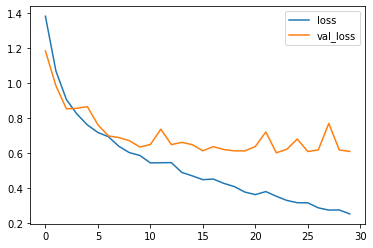

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

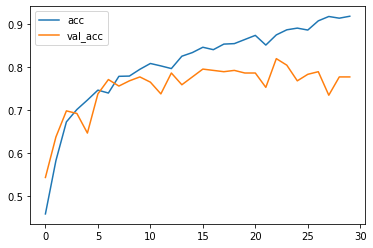

In [39]:
plt.plot(history.history['categorical_accuracy'], label='acc')
plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Evaluating

In [40]:
# Evaluating the model on test data

filenames = test_gen.filenames
nb_samples = len(filenames)

model.evaluate_generator(test_gen, nb_samples)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.6111918687820435, 0.7774389982223511]

In [41]:
# Generating predictions on test data

test_x, test_y = test_gen.__getitem__(1)
preds = model.predict(test_x)

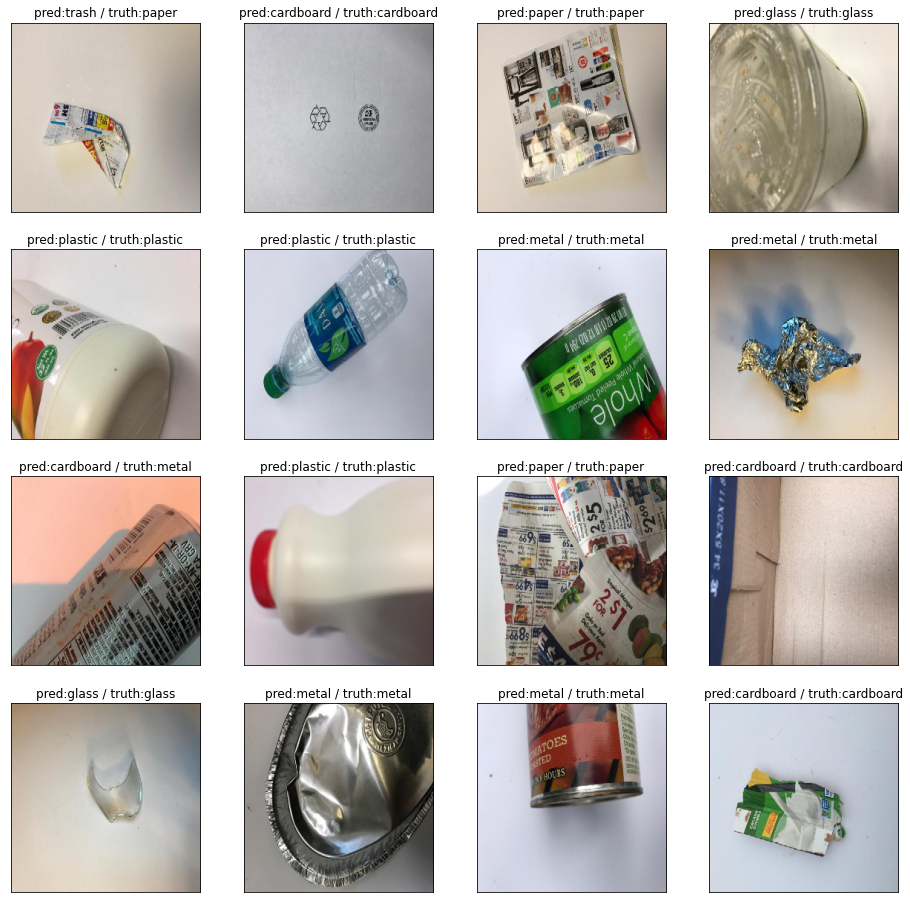

In [42]:
# Comparing predcitons with original labels

labels = (gen_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

Confusion Matrix


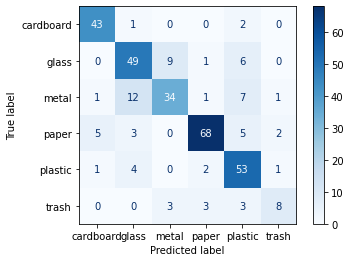

In [43]:
# Confusion Matrix

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [44]:
# Accuracy

acc = accuracy_score(test_gen.classes, y_pred)
print("Accuracy is {} percent".format(round(acc*100,2)))

Accuracy is 77.74 percent
